<a href="https://colab.research.google.com/github/dinhco01/MushroomClassification_CS231/blob/main/keras_retinanet/train_model_retinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import library**

In [2]:
!git clone https://github.com/DaiVo20/za_traffic_detection

Cloning into 'za_traffic_detection'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (187/187), done.
remote: Total 233 (delta 68), reused 186 (delta 39), pack-reused 0
Receiving objects: 100% (233/233), 35.15 MiB | 28.79 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [4]:
import os
import cv2
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.data import TFRecordDataset
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from za_traffic_detection.keras_retinanet.retinanet.utils import try_ignore_error
from za_traffic_detection.keras_retinanet.retinanet.losses import RetinaNetLoss
from za_traffic_detection.keras_retinanet.retinanet.model import LabelEncoder, RetinaNet
import za_traffic_detection.keras_retinanet.retinanet.model as m
from za_traffic_detection.keras_retinanet.retinanet.prediction import Prediction
from za_traffic_detection.keras_retinanet.retinanet.data_processing import write_tfrecords, DataProcessing
from za_traffic_detection.keras_retinanet.retinanet.utils import visualize_detections

# **Prepare data**

In [14]:
df_train = pd.read_csv('/content/drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/train_filter.csv')
df_train['width'] = df_train['xmax'] - df_train['xmin']
df_train['height'] = df_train['ymax'] - df_train['ymin']

In [15]:
df_test = pd.read_csv('/content/drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_public_test/test.csv')
df_test['width'] = df_test['xmax'] - df_test['xmin']
df_test['height'] = df_test['ymax'] - df_test['ymin']

In [16]:
data_train = []

for index, row in tqdm(df_train.iterrows()):
    item = {}
    image_id = row['file_name'].split('/')[-1].split('.')[0]
    bbox = [row['xmin'], row['ymin'], row['width'], row['height']]
    label = row['label']

    item['id'] = image_id
    item['bbox'] = bbox
    item['label'] = label

    data_train.append(item)

9076it [00:01, 8190.84it/s]


In [20]:
TFRECORDS_FILE = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/train_model/images.tfrecords'
path_images = '/content/drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_train/images'
checkpoint_dir = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/train_model/weights'
os.makedirs(checkpoint_dir, exist_ok=True)

In [21]:
if not os.path.exists(TFRECORDS_FILE):
    print("Creating tfrecords dataset...")
    write_tfrecords(data_train, TFRECORDS_FILE, path_images)

Creating tfrecords dataset...


100%|██████████| 9076/9076 [26:07<00:00,  5.79it/s]


In [ ]:
autotune = tf.data.experimental.AUTOTUNE
batch_size = 10

fdataset = TFRecordDataset(TFRECORDS_FILE)
data_processor = DataProcessing(origin_width=405, origin_height=156, width=400, height=154)
label_encoder = LabelEncoder()

In [ ]:
train_data = fdataset.map(data_processor.preprocess_data)
train_data = train_data.shuffle(batch_size)
train_data = train_data.padded_batch(batch_size, padding_values=(0.0, 1e-8, tf.cast(-1, tf.int64)), drop_remainder=True)
train_data = train_data.map(label_encoder.encode_batch, num_parallel_calls=autotune)
train_data = train_data.apply(tf.data.experimental.ignore_errors())
train_data = train_data.prefetch(autotune)

# **Train model**

In [ ]:
number_class = 7
train_size = 18490
train_steps_per_epoch = train_size // batch_size
epochs = 50

In [ ]:
learning_rates = [1e-4, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = PiecewiseConstantDecay(boundaries=learning_rate_boundaries, values=learning_rates)
optimizer = SGD(learning_rate=learning_rate_fn, momentum=0.9)

callbacks_list = [
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_dir, 'weight_resnet50_{epoch}.h5'),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=3,
    )
]

model = RetinaNet(number_class, backbone="resnet50")
model.compile(optimizer=optimizer, loss=RetinaNetLoss(number_class))
model.build((1, None, None, 3))

In [ ]:
path_weight = os.path.join(checkpoint_dir, 'weight_resnet50.h5')
try_ignore_error(model.load_weights, path_weight)

In [ ]:
#Trained 53 epoch
history = model.fit(train_data.repeat(),
                    epochs=5,
                    steps_per_epoch=train_steps_per_epoch,
                    callbacks=callbacks_list,
                    initial_epoch=0)

Epoch 1/5
1125/1125 [==============================] - ETA: 0s - loss: 0.2947
Epoch 00001: saving model to /gdrive/MyDrive/Colab/ComputerVision/TrafficSign/TrafficSignDetection/weights/weight_resnet50.h5
1125/1125 [==============================] - 1994s 2s/step - loss: 0.2947
Epoch 2/5
1125/1125 [==============================] - ETA: 0s - loss: 0.3027
Epoch 00002: saving model to /gdrive/MyDrive/Colab/ComputerVision/TrafficSign/TrafficSignDetection/weights/weight_resnet50.h5
1125/1125 [==============================] - 1974s 2s/step - loss: 0.3027
Epoch 3/5
1125/1125 [==============================] - ETA: 0s - loss: 0.3499
Epoch 00003: saving model to /gdrive/MyDrive/Colab/ComputerVision/TrafficSign/TrafficSignDetection/weights/weight_resnet50.h5
1125/1125 [==============================] - 1975s 2s/step - loss: 0.3499
Epoch 4/5
1125/1125 [==============================] - ETA: 0s - loss: 0.3003
Epoch 00004: saving model to /gdrive/MyDrive/Colab/ComputerVision/TrafficSign/TrafficSig

# **Evaluate**

In [26]:
def get_inference_model(weight_path, confidence_threshold=0.05, nms_iou_threshold=0.5, backbone="resnet50"):
    num_of_classes = 7
    model = RetinaNet(num_of_classes, backbone=backbone)
    model.compile(optimizer="adam", loss=RetinaNetLoss(num_of_classes))
    model.build((1, None, None, 3))
    image = tf.keras.Input(shape=[None, None, 3], name="image")
    model.load_weights(weight_path)
    predictions = model(image, training=False)
    detections = m.DecodePredictions(confidence_threshold=confidence_threshold,
                                     num_classes=num_of_classes,
                                     max_detections_per_class=10,
                                     nms_iou_threshold=nms_iou_threshold,
                                     verbose=0)(image, predictions)

    inference_model = tf.keras.Model(inputs=image, outputs=detections)

    return inference_model

In [ ]:
path_save_label = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/train_model/label'
os.makedirs(path_save_label, exist_ok=True)

path_save_predict = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/train_model/predict'
os.makedirs(path_save_predict, exist_ok=True)

In [ ]:
index_class = {
    1: "no_entry",
    2: "no_parking_waiting",
    3: "no_turning",
    4: "max_speed",
    5: "other_prohibition_signs",
    6: "warning",
    7: "mandatory"
}

In [ ]:
df_test_copy = df_test.copy()
df_test_copy['class_'] = df_test_copy['label'].replace(index_class)
img_names = df_test_copy.file_name.unique()

grouped = df_test_copy.groupby(df_test_copy.file_name)
for file_name in tqdm(img_names):
    img_name = file_name.split('/')[-1].split('.')[0]
    item = grouped.get_group(file_name)
    item = item.loc[:,['xmin', 'ymin', 'width', 'height', 'class_']]
    item = item.reindex(columns=['class_', 'xmin', 'ymin', 'width', 'height'])
    item.to_csv(os.path.join(path_save_label, img_name + '.txt'), sep=' ', index=False, header=None)

In [ ]:
path_weight = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/train_model/weights/weight_resnet50.h5'
inference_model = get_inference_model(path_weight, backbone='resnet50')
predictor = Prediction(inference_model)

In [ ]:
for index, file_name in tqdm(enumerate(img_names)):
    img_name = file_name.split('/')[-1].split('.')[0]
    dict_predict = {'class':[], 'confidence':[], 'x':[], 'y':[], 'w':[], 'h':[]}
    img = cv2.imread(file_name)[..., ::-1]
    image, boxes, scores, classes = predictor.detect_single_image(img, tiling=True)
    for box, score, class_ in zip(boxes, scores, classes):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        confidence = score.numpy()

        dict_predict['class'].append(index_class[class_.numpy().astype(int)])
        dict_predict['confidence'].append(confidence)
        dict_predict['x'].append(round(x1.numpy(), 0).astype(int))
        dict_predict['y'].append(round(y1.numpy(), 0).astype(int))
        dict_predict['w'].append(round(w.numpy(), 0).astype(int))
        dict_predict['h'].append(round(h.numpy(), 0).astype(int))
    
    pd.DataFrame(dict_predict).to_csv(os.path.join(path_save_predict, img_name + '.txt'), sep=' ', index=False, header=None)

568it [1:16:48,  8.11s/it]


In [22]:
!python /content/za_traffic_detection/keras_retinanet/evaluation/pascalvoc.py -gt /content/drive/MyDrive/TrafficSign/Model/RetinaNet/train_model/label -det /content/drive/MyDrive/TrafficSign/Model/RetinaNet/train_model/predict



###########################################################################################
#                                                                                         #
# This sample shows how to evaluate object detections applying the following metrics:     #
#  * Precision x Recall curve       ---->       used by VOC PASCAL 2012)                  #
#  * Average Precision (AP)         ---->       used by VOC PASCAL 2012)                  #
#                                                                                         #
# Developed by: Rafael Padilla (rafael.padilla@smt.ufrj.br)                               #
#        SMT - Signal Multimedia and Telecommunications Lab                               #
#        COPPE - Universidade Federal do Rio de Janeiro                                   #
#        Last modification: Feb 12th 2021                                                 #
##############################################################################

# **Predict**

In [27]:
path_weight = '/content/drive/MyDrive/TrafficSign/Model/RetinaNet/train_model/weights/weight_resnet50.h5'
inference_model = get_inference_model(path_weight, confidence_threshold=0.5, backbone='resnet50')
predictor = Prediction(inference_model)

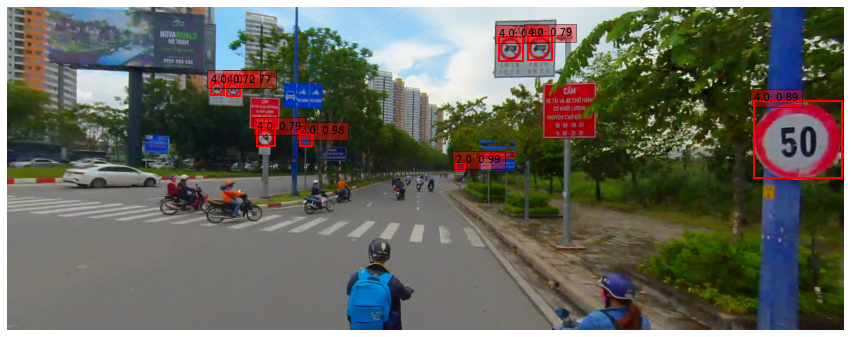

In [29]:
path_img = os.path.join('/content/drive/MyDrive/TrafficSign/data/za_traffic_2020/traffic_public_test/images', '479.png')
img = cv2.imread(path_img)[..., ::-1]
image, boxes, scores, classes = predictor.detect_single_image(img, tiling=True)
visualize_detections(image, boxes, classes, scores)